### Procedure for Evaluation : Chinese Samples - Smriti

* Open taxon, collector, geography gt-labels and the gpt-resized-results 
* Check if gpt-file has attribute of scientificname, collected by / recorded by, country/locality
* Make count of all comparable files (some don't have valid responses - ignore these)
* Check match of the gt with produced labels (if produced label in gt) or perhaps some better match method (similarity measures)
* Count number of matches with some threshold value ->50% match 
* Measure of accuracy 

In [1]:
#installations necessary
# pip install taxonerd
# pip install https://github.com/nleguillarme/taxonerd/releases/download/v1.5.0/en_core_eco_biobert-1.0.2.tar.gz
# pip install tqdm
# pip install seaborn

In [2]:
#import statements
import os
import pandas as pd
import numpy as np
import re
from taxonerd import TaxoNERD
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
print(os.getcwd())
# os.chdir("gt_labels/")
# os.chdir("../ml-herbarium-data/scraped-data/drago_testdata/gt_labels")
os.chdir('ChineseImages/')
gt = pd.read_csv('chineseHerbarium.csv')

/projectnb/sparkgrp/ml-herbarium-grp/fall2023


In [4]:
gt.head()

,ReferenceID,Scientific Name,Chinese Name,Identified By,Identification Date,Collector,Collector's No,Collection Date,Locality,Elevation,Habitat,Reproductive Condition
0,1,Callicarpa giraldii Hesse ex Rehder,老鸦糊,林祁,20170702,"陈耀东, 马欣堂, 杜玉芬, 班勤",5008,19900707,中国 安徽省,370,山坡林中,有花有果
1,2,Arisaema erubescens Schott,一把伞南星,马政旭,NaN,NaN,467,19710728,中国 河北省,NaN,山沟林下,有花有果
2,3,Arisaema heterophyllum Blume,天南星,林祁,20170702,NaN,20086,19900512,中国 贵州省,790,杂木林下,有花有果
3,4,Saurauia tristyla DC.,水东哥,林祁,20170702,云南二队,151,19670421,中国 云南省,800,山坡丛林,有花有果
4,5,Juncus Linn,灯心草属,林祁,20170702,榆东组,5,19680714,中国 陕西省,NaN,NaN,有花无果


In [5]:
gt = gt.rename(columns={'ReferenceID': 'ID'})

In [6]:
#Load the azure vision results
os.chdir('../ChineseResults/')
print(os.getcwd())
# os.chdir('/projectnb/sparkgrp/ml-herbarium-grp/fall2023/temp/')

folder_path = os.getcwd()
result_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(('txt'))]

#checking for duplicate files
print(len(result_files)==len(set(result_files)))
rows = []
for i in result_files:
    # print(i)
    # break
    f = open(i, 'r')
    lines = f.readlines()
    new_row=[]
    taxon_res=""
    geo_res=""
    col_res=""
    
    for line in lines:
        if "scientificname\":" in line.lower():
            taxon_res=line.strip().split(":")[1].replace(",","").replace('"', '').lstrip()
        if "country\":" in line.lower():
            geo_res=line.strip().split(":")[1].replace(",","").replace('"', '').lstrip()
        if "collectedby\":" in line.lower() or "recordedby\":" in line.lower() or "collector\":" in line.lower():
            # print(line.strip().split(":"))
            col_res=line.strip().split(":")[1].replace(",","").replace('"', '').lstrip()
            
    new_row = [i.replace('.txt',''),taxon_res,col_res,geo_res]
    rows.append(new_row)
    f.close()


/projectnb/sparkgrp/ml-herbarium-grp/fall2023/ChineseResults
True


In [7]:
rt = pd.DataFrame(rows, columns=['ID', 'rTaxon', 'rCollector', 'rGeography'])

In [8]:
len(rt)

37

In [9]:
rt.isnull().values.any()

False

In [10]:
import numpy as np
np.where(pd.isnull(rt))

(array([], dtype=int64), array([], dtype=int64))

In [11]:
np.where(rt.map(lambda x: x == ''))

(array([ 0,  1,  1,  2,  4,  5,  6,  7,  8,  8,  9, 10, 11, 12, 13, 14, 14,
        16, 16, 16, 17, 18, 19, 19, 21, 21, 22, 22, 23, 24, 25, 27, 29, 29,
        29, 30, 31, 31, 32, 32, 34, 35, 35, 36, 36, 36]),
 array([2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 3, 2, 1,
        1, 2, 2, 3, 1, 2, 2, 2, 1, 2, 1, 2, 3, 2, 1, 2, 1, 2, 2, 1, 2, 1,
        2, 3]))

### Noting down empty values

In [12]:
rt[rt['rTaxon'] == '']['ID']

1     21
8     23
11    27
14    31
16     3
18    18
19    11
22    22
25    33
29     7
31    13
32    24
35    10
36     5
Name: ID, dtype: object

In [13]:
rt[rt['rCollector'] == '']['ID']

0     28
1     21
2     32
4     25
5     36
6     19
7     12
8     23
9     16
10    34
12    20
13     4
14    31
16     3
17    35
19    11
21    29
22    22
23     9
24     1
27    26
29     7
30    30
31    13
32    24
34    17
35    10
36     5
Name: ID, dtype: object

In [14]:
rt[rt['rGeography'] == '']['ID']

16     3
21    29
29     7
36     5
Name: ID, dtype: object

## Comparison with Ground Truth Labels

### 1. Accuracy with direct comparison

In [15]:
rt['ID'] = rt['ID'].astype(str).astype(int)

In [16]:
new_df = (pd.merge(gt, rt, on='ID'))

In [17]:
new_df.head()

,ID,Scientific Name,Chinese Name,Identified By,Identification Date,Collector,Collector's No,Collection Date,Locality,Elevation,Habitat,Reproductive Condition,rTaxon,rCollector,rGeography
0,1,Callicarpa giraldii Hesse ex Rehder,老鸦糊,林祁,20170702,"陈耀东, 马欣堂, 杜玉芬, 班勤",5008,19900707,中国 安徽省,370,山坡林中,有花有果,Clerodendrum japonicum (Thunb.) Sweet,,China
1,2,Arisaema erubescens Schott,一把伞南星,马政旭,NaN,NaN,467,19710728,中国 河北省,NaN,山沟林下,有花有果,Caliarpa girakai,Ribe.,unknown
2,3,Arisaema heterophyllum Blume,天南星,林祁,20170702,NaN,20086,19900512,中国 贵州省,790,杂木林下,有花有果,,,
3,4,Saurauia tristyla DC.,水东哥,林祁,20170702,云南二队,151,19670421,中国 云南省,800,山坡丛林,有花有果,Saarmia oistyla,,China
4,5,Juncus Linn,灯心草属,林祁,20170702,榆东组,5,19680714,中国 陕西省,NaN,NaN,有花无果,,,


In [18]:
np.where(pd.isnull(new_df))

(array([ 1,  1,  1,  2,  4,  4,  8,  8,  8, 15, 15, 15, 17, 18, 19, 19, 19,
        21, 21, 24, 25, 26, 27, 28, 30, 30, 30, 31, 32, 34, 34, 34, 34]),
 array([ 4,  5,  9,  5,  9, 10,  3,  4, 10,  5,  9, 10,  9,  9,  2,  9, 10,
         3,  4,  5,  9,  9,  2,  1,  3,  4, 10,  9,  9,  3,  6,  9, 10]))

In [19]:
np.where(new_df.map(lambda x: x == ''))

(array([ 0,  2,  2,  2,  3,  4,  4,  4,  6,  6,  6,  8,  9,  9, 10, 10, 11,
        12, 12, 15, 16, 17, 18, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 25,
        26, 27, 28, 28, 29, 30, 30, 31, 32, 33, 34, 35]),
 array([13, 12, 13, 14, 13, 12, 13, 14, 12, 13, 14, 13, 12, 13, 12, 13, 13,
        12, 13, 13, 13, 12, 13, 13, 12, 13, 12, 13, 12, 13, 12, 13, 13, 13,
        12, 13, 13, 14, 13, 12, 13, 13, 12, 13, 13, 13]))

In [20]:
len(new_df)

37

In [21]:
##Replacing all USA variations with one label

# for i in new_df['rGeography']:
#     if i=="USA" in i or "United States" in i:

new_df['rGeography'] = new_df['rGeography'].apply(lambda i: "united states of america" if i.lower() in ["usa","united states","us"] else i)

In [23]:
new_df[new_df['rGeography'].str.startswith("U")]

,ID,Scientific Name,Chinese Name,Identified By,Identification Date,Collector,Collector's No,Collection Date,Locality,Elevation,Habitat,Reproductive Condition,rTaxon,rCollector,rGeography
12,13,Skimmia reevesiana R.Fortune,茵芋,林祁,20170702,调查队,660476,19660423,中国 江西省,1600,山顶沟谷矮林中,有花无果,,,Unable to determine; possibly inferred from th...
27,28,Corydalis balsamiflora Prain,NaN,Magnus Liden,20170000,"张永田,郎楷永",4,19650626,中国 四川省,2750,山坡水边,有花无果,Ceridalo babamitors Prun,,Unknown


In [24]:
p = re.compile(r'[^\w\s]+')

for i in new_df[['Scientific Name','rTaxon']]:
    if i=="ID":
        continue
    new_df[i] = new_df[i].astype(str)
    new_df[i] = new_df[i].str.lower()
    new_df[i] = [p.sub('', x) for x in new_df[i].tolist()]

In [25]:
new_df.head()

,ID,Scientific Name,Chinese Name,Identified By,Identification Date,Collector,Collector's No,Collection Date,Locality,Elevation,Habitat,Reproductive Condition,rTaxon,rCollector,rGeography
0,1,callicarpa giraldii hesse ex rehder,老鸦糊,林祁,20170702,"陈耀东, 马欣堂, 杜玉芬, 班勤",5008,19900707,中国 安徽省,370,山坡林中,有花有果,clerodendrum japonicum thunb sweet,,China
1,2,arisaema erubescens schott,一把伞南星,马政旭,NaN,NaN,467,19710728,中国 河北省,NaN,山沟林下,有花有果,caliarpa girakai,Ribe.,unknown
2,3,arisaema heterophyllum blume,天南星,林祁,20170702,NaN,20086,19900512,中国 贵州省,790,杂木林下,有花有果,,,
3,4,saurauia tristyla dc,水东哥,林祁,20170702,云南二队,151,19670421,中国 云南省,800,山坡丛林,有花有果,saarmia oistyla,,China
4,5,juncus linn,灯心草属,林祁,20170702,榆东组,5,19680714,中国 陕西省,NaN,NaN,有花无果,,,


## Taxon Metrics

### 1. Accuracy

In [60]:
#Taxon accuracy - count as 1 only if ground truth label is present as is in extracted label
c=0
for index, row in new_df.iterrows():
    if row['Scientific Name'].lower() in row['rTaxon'].lower():
        c+=1

In [61]:
print(c)

0


In [62]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 0.0%


In [63]:
# Approach 2 : count as 1 if any word in ground truth label is present in extracted label

c=0
for index, row in new_df.iterrows():
    if any(x in row['rTaxon'].lower() for x in row['Scientific Name'].lower().split()):
        c+=1

In [64]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 2.7027027027027026%


In [65]:
tax_acc = acc

In [66]:
# Approach 3 : count as 1 if all words in ground truth label is present in extracted label (need not be in order)

c=0
for index, row in new_df.iterrows():
    if(set(row['Scientific Name'].lower().split()).issubset(set(row['rTaxon'].lower().split()))):
        c+=1

In [67]:
print(c)

0


In [68]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 0.0%


### 2. Different Approach : Compare words in the whole text not just specific labels

In [69]:
#Load the azure vision results
os.chdir('../ChineseResults/')
print(os.getcwd())
# os.chdir('/projectnb/sparkgrp/ml-herbarium-grp/fall2023/temp/')

folder_path = os.getcwd()
result_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(('txt'))]

#checking for duplicate files
print(len(result_files)==len(set(result_files)))
rows = []
for i in result_files:
    # print(i)
    # break
    f = open(i, 'r')
    text = f.read().strip()
    new_row = [i.replace('.txt',''),text]
    rows.append(new_row)
    f.close()

/projectnb/sparkgrp/ml-herbarium-grp/fall2023/ChineseResults
True


In [70]:
rt = pd.DataFrame(rows, columns=['ID', 'Text'])

In [71]:
p = re.compile(r'[^\w\s]+')

for i in rt[['Text']]:
    rt[i] = rt[i].astype(str)
    rt[i] = rt[i].str.lower()
    rt[i] = [p.sub('', x) for x in rt[i].tolist()]

In [72]:
rt.head()

,ID,Text
0,28,the text youve provided appears to refer to a ...
1,21,based on the information provided it seems to ...
2,32,from the description provided we can attempt t...
3,15,to create a json form in darwin core format we...
4,25,to provide the relevant darwin core informatio...


In [73]:
gt.head()

,ID,Scientific Name,Chinese Name,Identified By,Identification Date,Collector,Collector's No,Collection Date,Locality,Elevation,Habitat,Reproductive Condition
0,1,callicarpa giraldii hesse ex rehder,老鸦糊,林祁,20170702,"陈耀东, 马欣堂, 杜玉芬, 班勤",5008,19900707,中国 安徽省,370,山坡林中,有花有果
1,2,arisaema erubescens schott,一把伞南星,马政旭,NaN,NaN,467,19710728,中国 河北省,NaN,山沟林下,有花有果
2,3,arisaema heterophyllum blume,天南星,林祁,20170702,NaN,20086,19900512,中国 贵州省,790,杂木林下,有花有果
3,4,saurauia tristyla dc.,水东哥,林祁,20170702,云南二队,151,19670421,中国 云南省,800,山坡丛林,有花有果
4,5,juncus linn,灯心草属,林祁,20170702,榆东组,5,19680714,中国 陕西省,NaN,NaN,有花无果


In [74]:
gt.loc[3]['Identified By'] == gt.loc[4]['Identified By']

True

In [75]:
gt['Scientific Name'] = gt['Scientific Name'].str.lower()

In [76]:
scores = []

for index, row in gt.iterrows():
    c=0.0
    row1 = list(row.values)
    d=0
    for word in row1:
        for w in str(word).split(" "):
            d+=1
            # print(w, rt.loc[rt['ID']==str(row1[0]), 'Text'].item())
            if str(w) in rt.loc[rt['ID']==str(row1[0]), 'Text'].item():
                # print(w)
                c+=1.0
    scores.append(c/d)        

In [77]:
print(scores)

[0.14285714285714285, 0.0, 0.0, 0.13333333333333333, 0.0, 0.13333333333333333, 0.06666666666666667, 0.047619047619047616, 0.1875, 0.0, 0.058823529411764705, 0.0, 0.06666666666666667, 0.06666666666666667, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.06666666666666667, 0.0, 0.07142857142857142, 0.0, 0.0, 0.0, 0.0625, 0.13043478260869565, 0.058823529411764705, 0.0, 0.06666666666666667, 0.06666666666666667, 0.125, 0.0, 0.10526315789473684, 0.0625, 0.0, 0.06666666666666667]


In [78]:
len(scores)

37

In [79]:
combined_score = sum(scores)/37

print(combined_score)

0.05007431787112766


## Collector Metrics

### 1. Accuracy

In [80]:
new_df = new_df.fillna("")

In [81]:
#Approach 1 - count as 1 only if ground truth label is present as is in extracted label
c=0
for index, row in new_df.iterrows():
    if row['Collector'].lower() in row['rCollector'].lower():
        c+=1

In [82]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 10.81081081081081%


In [83]:
col_acc = acc

In [84]:
# Approach 2 : count as 1 if any word in ground truth label is present in extracted label

c=0
for index, row in new_df.iterrows():
    if any(x in row['rCollector'].lower() for x in row['Collector'].lower().split()):
        print(row['Collector'].lower(), row['rCollector'].lower())
        c+=1

In [85]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 0.0%


In [86]:
# Approach 3 : count as 1 if all words in ground truth label is present in extracted label (need not be in order)

c=0
for index, row in new_df.iterrows():
    if(set(row['Collector'].lower().split()).issubset(set(row['rCollector'].lower().split()))):
        c+=1

In [87]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 10.81081081081081%


## Geography Metrics

### 1. Accuracy

In [88]:
#Approach 1 - count as 1 only if ground truth label is present as is in extracted label
c=0
for index, row in new_df.iterrows():
    
    if row['Locality'].lower() in row['rGeography'].lower():
        # print(row['Geography'].lower(), row['rGeography'].lower())
        c+=1

In [89]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 0.0%


In [90]:
# Approach 2 : count as 1 if any word in ground truth label is present in extracted label

c=0
for index, row in new_df.iterrows():
    if any(x in row['rGeography'].lower() for x in row['Locality'].lower().split()):
        # print(row['Geography'], row['rGeography'])
        c+=1

In [91]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 5.405405405405405%


In [92]:
geo_acc = acc

In [93]:
# Approach 3 : count as 1 if all words in ground truth label is present in extracted label (need not be in order)

c=0
for index, row in new_df.iterrows():
    if(set(row['Locality'].lower().split()).issubset(set(row['rGeography'].lower().split()))):
        c+=1

In [94]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 0.0%


## Visualizations

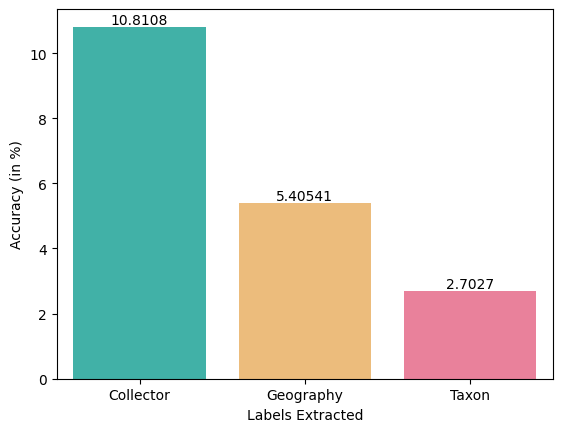

In [95]:
df_scores = pd.DataFrame({
        'Labels Extracted': ['Geography', 'Taxon', 'Collector'],
        'Accuracy (in %)': [geo_acc, tax_acc, col_acc]
})

df_scores = df_scores.sort_values(['Accuracy (in %)'], ascending=False).reset_index(drop=True)
# who v/s fare barplot 
palette=["#2ec4b6","#ffbf69","#fb6f92"]
ax = sns.barplot(x = 'Labels Extracted',
            y = 'Accuracy (in %)',
           data = df_scores,
           hue = 'Labels Extracted',
           palette=palette)

for i in ax.containers:
    ax.bar_label(i,)
# Show the plot
plt.show()

Note : We believe that the baseline for Chinese samples gives us unsatisfactory results since the Azure and GPT models might not be as trained to detect chinese characters as well as the others. We plan on employing some fine-tuning measures if possible in the future and delving into better, more specific evaluation metrics for Chinese character comparisons.